In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


iris = load_iris()
X,y = iris.data[50:, [1,2]], iris.target[50:]
le= LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline(
            [['sc', StandardScaler()],
            ['clf', clf1]]
        )
pipe3 = Pipeline(
            [['sc', StandardScaler()],
            ['clf', clf3]]
        )
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC Score for Classifier: {}, Mean: {}, Std: {}".format(label, round(scores.mean(),2), round(scores.std(),3))

ROC AUC Score for Classifier: Logistic Regression, Mean: 0.9166666666666667, Std: 0.2006932429798716
ROC AUC Score for Classifier: Decision Tree, Mean: 0.9166666666666667, Std: 0.15365907428821476
ROC AUC Score for Classifier: KNN, Mean: 0.9333333333333333, Std: 0.10408329997330663


In [14]:
from sklearn.ensemble import VotingClassifier

mv_clf = VotingClassifier(estimators=[('pipe1',pipe1), ('clf2',clf2), ('pipe3',pipe3)], voting='soft')
clf_labels.append('Majority Voting')

for clf, label in zip([pipe1, clf2, pipe3, mv_clf], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC Score for Classifier: {}, Mean: {}, Std: {}".format(label, round(scores.mean(),2), round(scores.std(),3)))

ROC AUC Score for Classifier: Logistic Regression, Mean: 0.92, Std: 0.201
ROC AUC Score for Classifier: Decision Tree, Mean: 0.92, Std: 0.154
ROC AUC Score for Classifier: KNN, Mean: 0.93, Std: 0.104
ROC AUC Score for Classifier: Majority Voting, Mean: 0.97, Std: 0.1


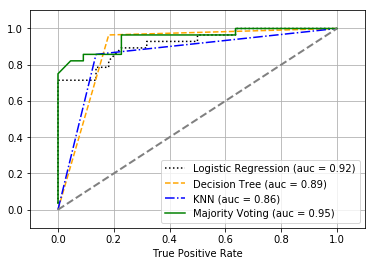

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue', 'green']
line_styles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip([pipe1, clf2, pipe3, mv_clf], clf_labels, colors, line_styles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, threashold = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label="{} (auc = {})".format(label, round(roc_auc, 2)))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.show()

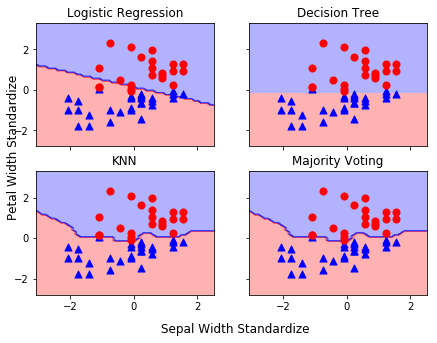

In [31]:
from itertools import product
from matplotlib.colors import ListedColormap

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_train))])

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),[pipe1, clf2, pipe3, mv_clf], clf_labels):
    clf.fit(X_train_std, y_train)
    Z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z=Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3,cmap=cmap)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^',s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o',s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s='Sepal Width Standardize', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal Width Standardize', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = [
    'Class Label',
    'Alcohol',
    'Malic Acid',
    'Ash',
    'Alcalinity of Ash',
    'Manganese',
    'Total Phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity',
    'Hue',
    'OD280/OD315 of diluted wines',
    'Proline'
]
df_wine = df_wine[df_wine['Class Label'] != 1]
X = df_wine[['Alcohol', 'Hue']].values
y = df_wine['Class Label'].values
y = LabelEncoder().fit_transform(y)

X_train , X_test, y_train, y_test = train_test_split(X,y, test_size=0.40, random_state=1)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0,
                        bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print("Decision Tree Accuracy : {}/{}".format(round(tree_test,3),tree_train))

Decision Tree Accuracy : 0.833/1.0


In [43]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print("Bagging Classifier Accuracy : {}/{}".format(round(bag_test,3),bag_train))

Bagging Classifier Accuracy : 0.896/1.0


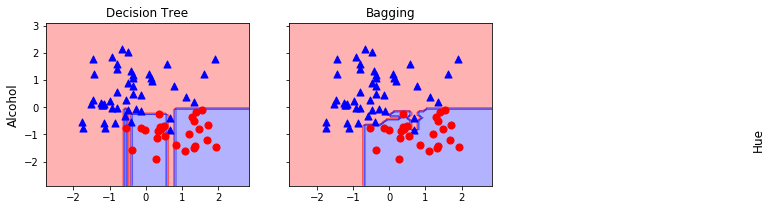

In [50]:
from matplotlib.colors import ListedColormap

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_train))])

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))
for idx, clf, tt in zip([0, 1], [tree, bag],['Decision Tree', 'Bagging']):
    clf.fit(X_train_std, y_train)
    Z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z=Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3,cmap=cmap)
    axarr[idx].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^',s=50)
    axarr[idx].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o',s=50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [53]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print("Ada Boost Classifier : {}/{}".format(round(ada_test,3),ada_train))

Ada Boost Classifier : 0.875/1.0


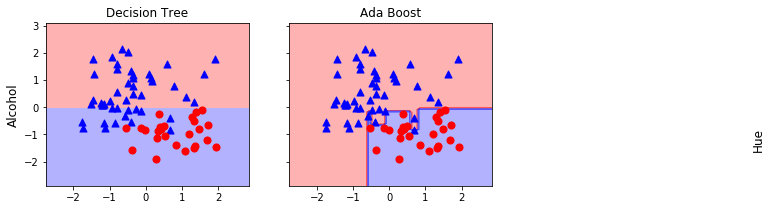

In [54]:
from matplotlib.colors import ListedColormap

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_train))])

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))
for idx, clf, tt in zip([0, 1], [tree, ada],['Decision Tree', 'Ada Boost']):
    clf.fit(X_train_std, y_train)
    Z=clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z=Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3,cmap=cmap)
    axarr[idx].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^',s=50)
    axarr[idx].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o',s=50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center', fontsize=12, rotation=90)
plt.show()